In [10]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from collections import Counter

from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
with open('./logregs_final/lr_bin_h-r_r-t_h-t_r-h_t-r_t-h.pkl', 'rb') as file:
    bin_model = pickle.load(file)
    
with open('./logregs_final/lr_multi_h-r_r-t_h-t_r-h_t-r_t-h.pkl', 'rb') as file:
    multi_model = pickle.load(file)

Feature importances for attention type

In [3]:
def plot_importance_binary(importance, name):
    ticks_idx = range(6)
    ticks_labels = 'h-r_r-t_h-t_r-h_t-r_t-h'.split('_')
    
    fig, ax = plt.subplots() 
    plt.bar([x for x in range(6)], [np.mean(abs(importance[x*144:(x+1)*144])) for x in range(6)])
#     plt.vlines([x for x in range(0, len(importance), 144)], ymin=0, ymax=max(importance), linestyles='dashed')
    ax.set_xticks(ticks_idx)
    ax.set_xticklabels(ticks_labels)
#     plt.title(f'LR {name} feature importance')
    plt.savefig(f'./images_paper/LR {name} feature importance.pdf')

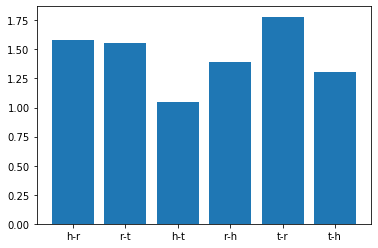

In [4]:
importance = bin_model.coef_[0]

plot_importance_binary(importance, name='binary')

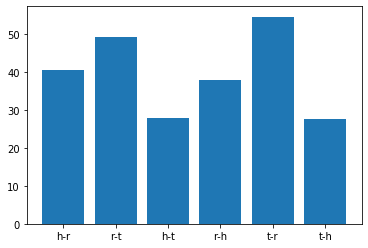

In [8]:
multi_importance = abs(multi_model.coef_)
multi_importance_sum = np.sum(multi_importance, axis=0)

plot_importance_binary(multi_importance_sum, name='multi')

Agglomerative clusterization

In [14]:
multi_importance = multi_model.coef_
class_labels = multi_model.classes_

In [15]:
rel_names = pd.read_csv('../data/meta/relations_trex.csv')
rel_names.head()

text_class_labels = []
for rel_label in class_labels:
    text_class_labels.append(f'{rel_names[rel_names.relation == rel_label].title.values[0]} ({rel_label})')

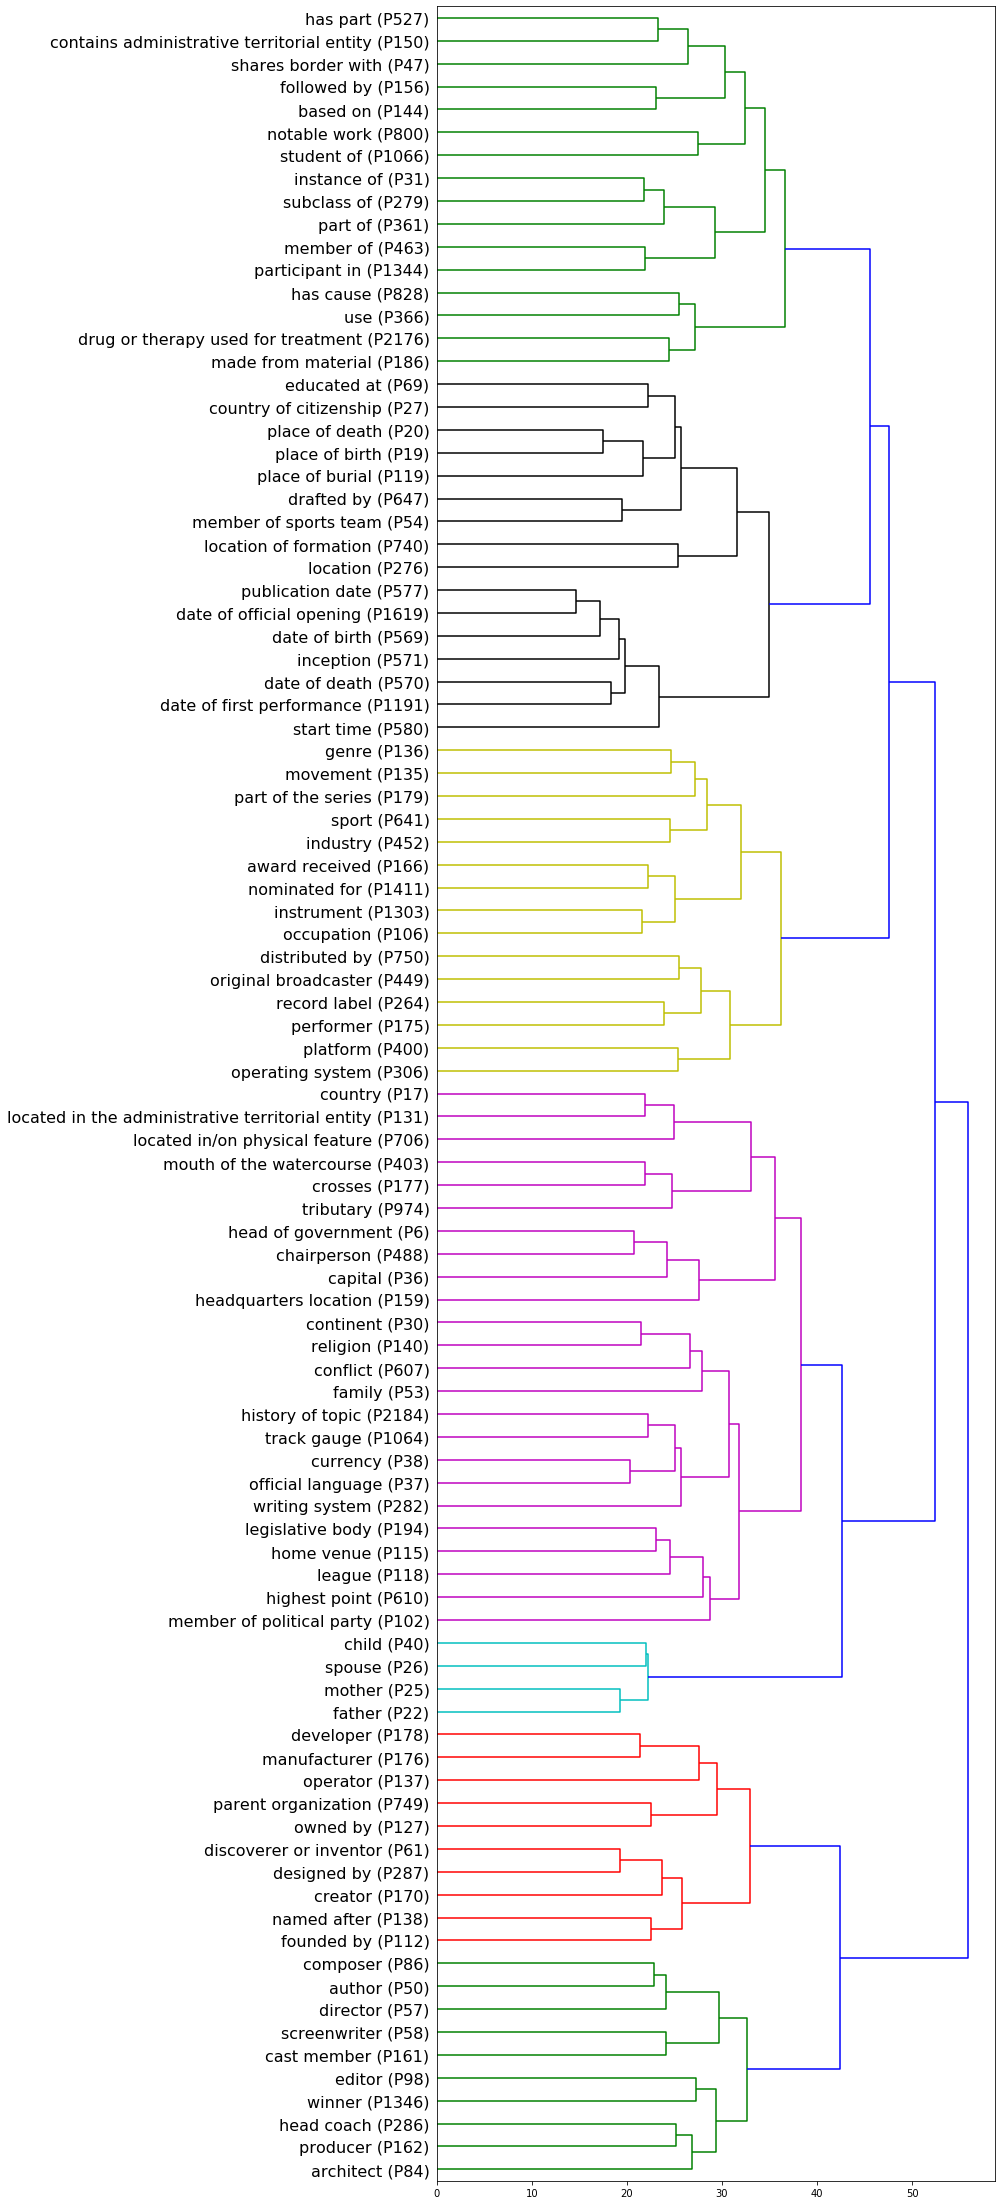

In [16]:
Z = linkage(multi_importance, 'ward')
fig = plt.figure(figsize=(10, 40))
dn = dendrogram(Z, labels=text_class_labels, leaf_font_size=16, leaf_rotation=0., orientation='right')
plt.savefig('./images_paper/dendrogram_eucl.pdf', bbox_inches="tight")

F1-score on different clusters

In [27]:
def get_one_score(comb_name):
    df = pd.read_csv(f'./logreg_models/cluster_combinations/report_multi_{comb_name}.csv', index_col=0)
    f1 = df.loc['weighted avg']['f1-score']
    num_clusters = df.shape[0] - 3
    
    return num_clusters, f1 

In [28]:
eucl_scores = []
eucl_cl_numbs = []

for i in range(25):
    num_clusters, f1 = get_one_score(f'comb_{i}')
    eucl_scores.append(f1)
    eucl_cl_numbs.append(num_clusters)

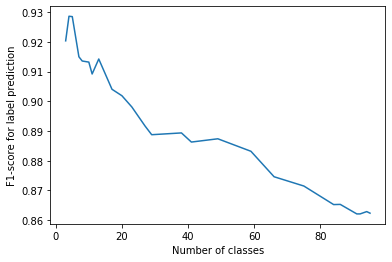

In [29]:
plt.plot(eucl_cl_numbs, eucl_scores)
# plt.title('F1-scores for multiclass classification')
plt.xlabel('Number of classes')
plt.ylabel('F1-score for label prediction')
plt.savefig('./images_paper/fscores_clusters.pdf')

F1-scores and other metric for certain layers 

In [31]:
def get_rel_scores(layer):
    df = pd.read_csv(f'./val_results/layers_probe_new/res_h-r_r-t_h-t_r-h_t-r_t-h_l{layer}.csv', index_col=0)
    df_multi = pd.read_csv(f'./logreg_models/layers_probe_new/report_multi_h-r_r-t_h-t_r-h_t-r_t-h_l{layer}.csv', index_col=0)
   
    precision = df.precision.values[:-1]
    recall = df.recall.values[:-1]
    f1 = df.f1.values[:-1]
    rel_pred_score = df_multi['f1-score'].values[:95]

    
    return precision, recall, f1, rel_pred_score

In [32]:
prec = []
rec = []
fscores = []
rel_scores = []

for l in range(12):
    precision, recall, f1, rel_pred_score = get_rel_scores(l)
    
    prec.append(precision)
    rec.append(recall)
    fscores.append(f1)
    rel_scores.append(rel_pred_score)

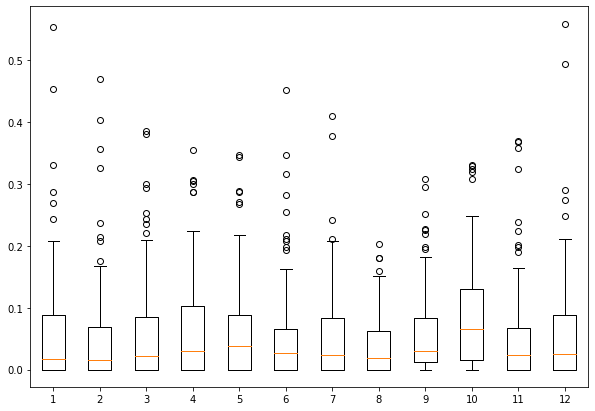

In [33]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot(fscores)
# plt.title('F-score for different relations (by layers zeroed)')

 
# show plot
plt.savefig('./images_paper/fscore_prediction_boxplot.pdf')

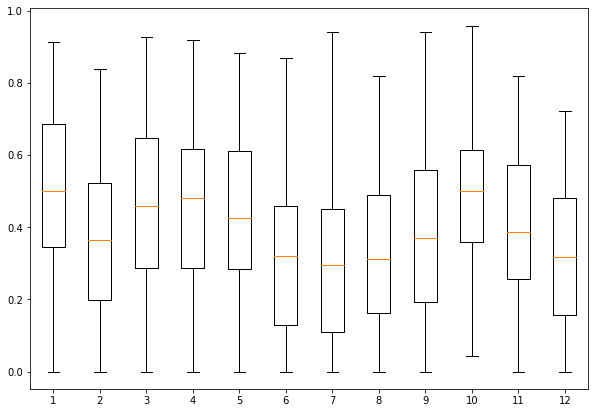

In [34]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot(rel_scores)
# plt.title('Rel prediction accuracy for different relations (by layers zeroed)')
 
# show plot
plt.savefig('./images_paper/rel_prediction_boxplot.pdf')